# Library

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from pandas import concat
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Loading Data

In [ ]:
df = pd.read_csv('../data/bank-full.csv', sep=';')
print("Data Loaded. Shape:", df.shape)
display(df.head())

Data Loaded. Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Preprocessing

In [15]:
features = [
    'age', 'job', 'marital', 'education', 'balance',
    'housing', 'loan', 'day', 'duration', 'campaign'
]

data_cluster = df[features].copy()

num_cols = ['age', 'balance', 'day', 'duration', 'campaign']
cat_cols = ['job', 'marital', 'education', 'housing', 'loan']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ]
)

X_processed = preprocessor.fit_transform(data_cluster)
if hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray()

print("Processing Done. Shape:", X_processed.shape)

Processing Done. Shape: (45211, 28)


# Clustering


Menghitung Elbow Method dan Silhouette Score...


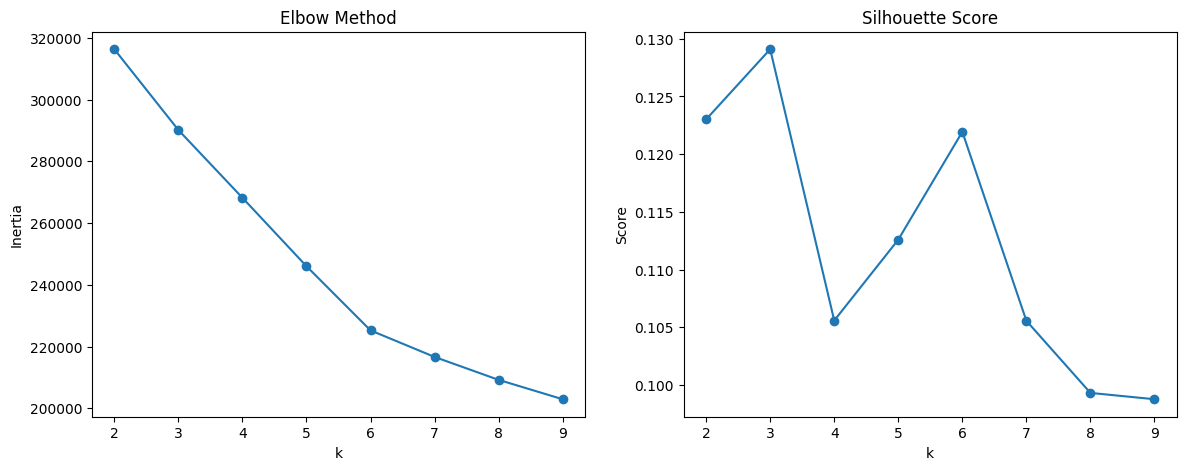

In [16]:
print("\nMenghitung Elbow Method dan Silhouette Score...")

inertias = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_processed)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_processed, labels))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")

plt.show()

# K-Means

In [17]:
best_k = K_range[sil_scores.index(max(sil_scores))]
print(f"Best k berdasarkan silhouette = {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans.fit_predict(X_processed)

Best k berdasarkan silhouette = 3


# GMM (HyperParameter Search)

In [18]:
print("\nGaussian Mixture Model: mencari komponen terbaik...")
gmm_scores = {}

for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_processed)
    gmm_scores[k] = gmm.bic(X_processed)

best_gmm_k = min(gmm_scores, key=gmm_scores.get)
print("Best GMM components:", best_gmm_k)

gmm = GaussianMixture(n_components=best_gmm_k, random_state=42)
df['Cluster_GMM'] = gmm.fit_predict(X_processed)


Gaussian Mixture Model: mencari komponen terbaik...
Best GMM components: 9


# DBSCAN


Mencari eps terbaik untuk DBSCAN...


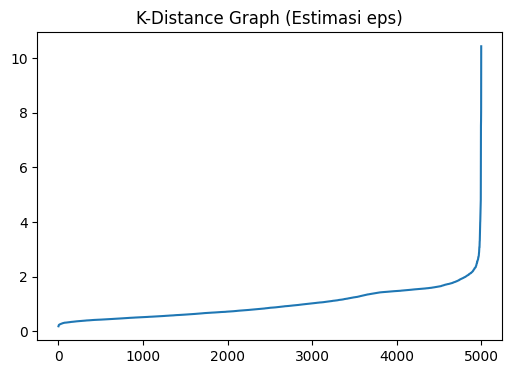

Estimasi eps: 1.895919553893036


In [19]:
print("\nMencari eps terbaik untuk DBSCAN...")

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_processed[:5000])
distances, _ = neighbors_fit.kneighbors(X_processed[:5000])
distances = np.sort(distances[:,4])

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title("K-Distance Graph (Estimasi eps)")
plt.show()

eps_est = float(distances[int(len(distances)*0.95)])
print("Estimasi eps:", eps_est)

dbscan = DBSCAN(eps=eps_est, min_samples=10)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_processed[:len(df)])

# PCA

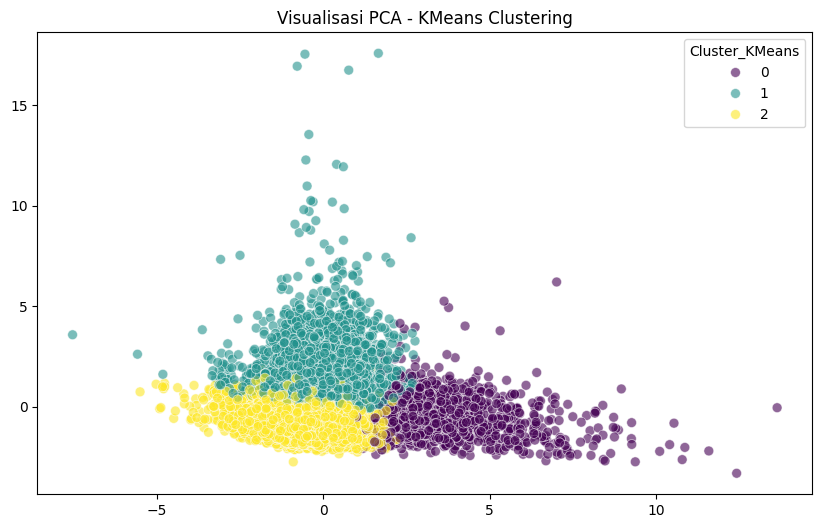

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df['Cluster_KMeans'], palette='viridis',
    s=50, alpha=0.6
)
plt.title("Visualisasi PCA - KMeans Clustering")
plt.show()

# Interpretasi

In [21]:
print("\n=== SUMMARY NUMERIK (MEAN per CLUSTER) ===")

summary_num = df.groupby("Cluster_KMeans")[num_cols].mean().round(2)
display(summary_num)

print("\n=== SUMMARY KATEGORI (Persentase per kategori) ===")

summary_cat = {}
all_cat_cols_for_df = []

for col in cat_cols:
    temp_original_cols = df.groupby("Cluster_KMeans")[col].apply(
        lambda x: x.value_counts(normalize=True) * 100
    ).unstack().fillna(0).round(2)

    summary_cat[col] = temp_original_cols

    temp_prefixed_cols = temp_original_cols.copy()
    temp_prefixed_cols.columns = [f"{col}_{cat}" for cat in temp_prefixed_cols.columns]
    all_cat_cols_for_df.append(temp_prefixed_cols)

summary_cat_df = concat(all_cat_cols_for_df, axis=1)

display(summary_cat_df)

print("\n=== INTERPRETASI OTOMATIS PER CLUSTER ===")

for cluster_id in sorted(df["Cluster_KMeans"].unique()):
    print(f"\n--- CLUSTER {cluster_id} ---")

    top_num = summary_num.loc[cluster_id].sort_values(ascending=False).head(3)
    low_num = summary_num.loc[cluster_id].sort_values().head(3)

    print("Ciri numerik tinggi:")
    for feat, val in top_num.items():
        print(f"  • {feat}: {val}")

    print("Ciri numerik rendah:")
    for feat, val in low_num.items():
        print(f"  • {feat}: {val}")

    print("Ciri kategori dominan (>50%):")
    for col in cat_cols:
        col_df = summary_cat[col].loc[cluster_id]
        dominant = col_df[col_df > 50]
        for cat_name, val in dominant.items():
            print(f"  • {col} = {cat_name} ({val}%)")


=== SUMMARY NUMERIK (MEAN per CLUSTER) ===


,age,balance,day,duration,campaign
Cluster_KMeans,,,,,
0,40.31,1120.14,22.07,159.48,13.97
1,51.94,1996.37,15.73,246.95,2.38
2,34.03,978.97,15.41,272.26,2.21



=== SUMMARY KATEGORI (Persentase per kategori) ===


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,marital_married,marital_single,education_secondary,education_tertiary,education_primary,education_unknown,housing_no,housing_yes,loan_no,loan_yes
Cluster_KMeans,,,,,,,,,,,,,,,,,,,,,
0,10.48,21.02,3.71,2.44,23.82,1.91,3.86,9.00,1.06,19.75,...,63.26,27.00,48.28,32.45,14.72,4.55,49.60,50.40,82.21,17.79
1,9.24,19.96,3.84,4.75,20.38,13.00,3.54,7.12,0.05,13.83,...,77.51,6.12,44.98,25.41,23.71,5.90,59.02,40.98,84.41,15.59
2,12.90,22.55,2.91,1.50,21.05,0.18,3.44,10.51,3.43,18.47,...,49.04,42.39,55.54,31.74,9.78,2.94,34.82,65.18,83.83,16.17



=== INTERPRETASI OTOMATIS PER CLUSTER ===

--- CLUSTER 0 ---
Ciri numerik tinggi:
  • balance: 1120.14
  • duration: 159.48
  • age: 40.31
Ciri numerik rendah:
  • campaign: 13.97
  • day: 22.07
  • age: 40.31
Ciri kategori dominan (>50%):
  • marital = married (63.26%)
  • housing = yes (50.4%)
  • loan = no (82.21%)

--- CLUSTER 1 ---
Ciri numerik tinggi:
  • balance: 1996.37
  • duration: 246.95
  • age: 51.94
Ciri numerik rendah:
  • campaign: 2.38
  • day: 15.73
  • age: 51.94
Ciri kategori dominan (>50%):
  • marital = married (77.51%)
  • housing = no (59.02%)
  • loan = no (84.41%)

--- CLUSTER 2 ---
Ciri numerik tinggi:
  • balance: 978.97
  • duration: 272.26
  • age: 34.03
Ciri numerik rendah:
  • campaign: 2.21
  • day: 15.41
  • age: 34.03
Ciri kategori dominan (>50%):
  • education = secondary (55.54%)
  • housing = yes (65.18%)
  • loan = no (83.83%)


# Inverse

In [22]:
def get_original_centroids(kmeans_model, preprocessor_model):
    """
    Fungsi untuk mengembalikan nilai asli dari centroid KMeans
    yang sudah terlanjur di-scale dan di-encode.
    """
    centers = kmeans_model.cluster_centers_

    scaler = preprocessor_model.named_transformers_['num']
    encoder = preprocessor_model.named_transformers_['cat']

    n_num = len(scaler.get_feature_names_out())

    centers_num = centers[:, :n_num]
    centers_cat = centers[:, n_num:]

    inv_num = scaler.inverse_transform(centers_num)
    inv_cat = encoder.inverse_transform(centers_cat)

    cols_num = num_cols
    cols_cat = cat_cols

    df_num = pd.DataFrame(inv_num, columns=cols_num)
    df_cat = pd.DataFrame(inv_cat, columns=cols_cat)

    df_final = pd.concat([df_num, df_cat], axis=1)
    df_final.insert(0, "Cluster", range(len(df_final)))

    return df_final.round(2)

df_centroids_real = get_original_centroids(kmeans, preprocessor)

print("\n=== PROFIL CLUSTER (NILAI ASLI / REAL VALUES) ===")
display(df_centroids_real)


=== PROFIL CLUSTER (NILAI ASLI / REAL VALUES) ===


,Cluster,age,balance,day,duration,campaign,job,marital,education,housing,loan
0,0,40.31,1120.14,22.07,159.48,13.97,management,married,secondary,yes,no
1,1,51.94,1996.69,15.73,247.05,2.38,management,married,secondary,no,no
2,2,34.03,978.73,15.41,272.20,2.21,blue-collar,married,secondary,yes,no


# Tambahkan Fitur Cluster

In [23]:
segment = {
    0: "Stable Productive",
    1: "High-Income Senior",
    2: "Responsive Young"
}

df["segment"] = df["Cluster_KMeans"].map(segment)

cols_to_drop = [
    "Cluster_KMeans",
    "Cluster_GMM",
    "Cluster_DBSCAN",
    "cluster_label"
]

df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

output_filename = "Data-Nasabah-clustering.csv"
df.to_csv(output_filename, index=False, sep=';')

print(f"\nFile saved: {output_filename}")
print(df.head().to_markdown(index=False))



File saved: Data-Nasabah-clustering.csv
|   age | job          | marital   | education   | default   |   balance | housing   | loan   | contact   |   day | month   |   duration |   campaign |   pdays |   previous | poutcome   | y   | segment            |
|------:|:-------------|:----------|:------------|:----------|----------:|:----------|:-------|:----------|------:|:--------|-----------:|-----------:|--------:|-----------:|:-----------|:----|:-------------------|
|    58 | management   | married   | tertiary    | no        |      2143 | yes       | no     | unknown   |     5 | may     |        261 |          1 |      -1 |          0 | unknown    | no  | High-Income Senior |
|    44 | technician   | single    | secondary   | no        |        29 | yes       | no     | unknown   |     5 | may     |        151 |          1 |      -1 |          0 | unknown    | no  | Responsive Young   |
|    33 | entrepreneur | married   | secondary   | no        |         2 | yes       | yes    | unk

In [24]:
print("\nJumlah data per Cluster:")
display(df['segment'].value_counts())


Jumlah data per Cluster:


,count
segment,
Responsive Young,26551
High-Income Senior,16771
Stable Productive,1889
